In [8]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Task 1

> Pасчет оценок максимального правдоподобия для различных объемов выборок с вычислением смещения (```bias_results```), дисперсии (```variance_results```), среднеквадратичной ошибки (```mse_results```) и количества выборок с оценкой параметра выше установленного порога (```out_of_threshold```)

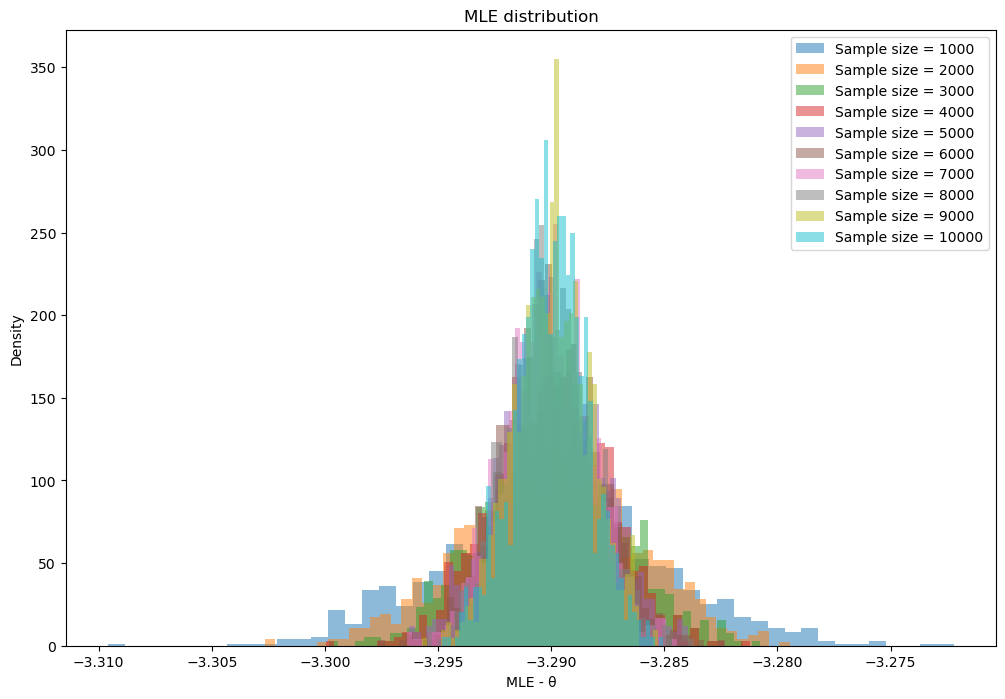

Bias: [-3.28993914 -3.29002867 -3.28998148 -3.29004865 -3.29002053 -3.28998642
 -3.29009776 -3.29009384 -3.28997725 -3.28997683]
Variance: [2.45659394e-05 1.40374976e-05 8.94211298e-06 6.30532726e-06
 4.93910585e-06 4.52891520e-06 3.74052549e-06 3.35949063e-06
 2.78347842e-06 2.48162914e-06]
MSE: [10.82372411 10.82430269 10.82398705 10.82442643 10.82424003 10.82401514
 10.82474704 10.8247208  10.82395306 10.82395   ]
Out of threshold: [13.  3.  0.  0.  0.  0.  0.  0.  0.  0.]


In [9]:

def f_theta(x, theta):
    return (3 * x**2 / np.sqrt(2 * np.pi)) * np.exp(-((theta - x**3)**2) / 2)

def log_likelihood(x, theta):
    return np.sum(np.log(f_theta(x, theta)))


# дифференциируем по тете и получаем
def mle(x):
    return np.cbrt(np.mean(x**3))


theta = 5
n_list = [i * 100 for i in range(1,11)]
m = 1000
threshold = 3.3

mle_results = np.zeros((len(n_list), m))
bias_results = np.zeros(len(n_list))
variance_results = np.zeros(len(n_list))
mse_results = np.zeros(len(n_list))
out_of_threshold = np.zeros(len(n_list))

for i, n in enumerate(n_list):
    for j in range(m):

        u = np.random.uniform(0, 1, n)
        x = np.cbrt(np.sqrt(2) * stats.norm.ppf(u) + theta)


        mle_results[i, j] = mle(x)


    bias_results[i] = np.mean(mle_results[i, :]) - theta
    variance_results[i] = np.var(mle_results[i, :])
    mse_results[i] = np.mean((mle_results[i, :] - theta)**2)

    #проверка абсолютной ошибки
    out_of_threshold[i] = np.sum(np.abs(mle_results[i, :] - theta) > threshold)


plt.figure(figsize=(12, 8))
for i, n in enumerate(n_list):
    plt.hist((mle_results[i, :] - theta), bins=50, density=True, alpha=0.5, label=f"Sample size = {n}")
plt.legend()
plt.xlabel("MLE - θ")
plt.ylabel("Density")
plt.title("MLE distribution")
plt.show()

print("Bias:", bias_results)
print("Variance:", variance_results)
print("MSE:", mse_results)
print("Out of threshold:", out_of_threshold)


- значения MSE высокие и остаются сравнительно стабильными по разным размерам выборки, что может объясняться сильным смещением оценки
- количество оценок, выходящих за пределы порога, уменьшается с увеличением размера выборки, что указывает на улучшение точности оценок при больших объемах данных
- несмещенность нет (мат ожидание == смещению (оценка совпадает с параметром))
- состоятельность нет (больше выборка => ближе к истинному значению параметра)
- асимптотическая нормальность(нормальное распр при большой выборке)
- эффективность нет

# Task 2

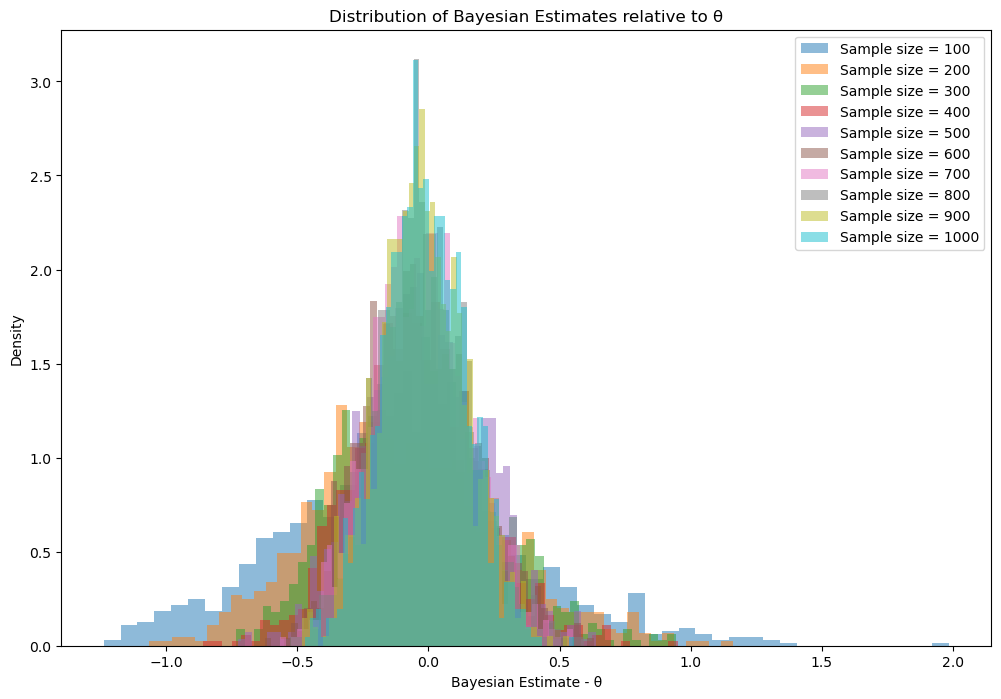

Bayesian Bias: [-0.11732395 -0.08693137 -0.04257058 -0.04095694 -0.02400423 -0.03130361
 -0.02734316 -0.01746333 -0.02014092 -0.01640334]
Bayesian Variance: [0.22960408 0.12489132 0.0788529  0.05866667 0.05011    0.04027392
 0.03466739 0.03112829 0.02721227 0.02455841]
Bayesian MSE: [0.24336899 0.13244838 0.08066515 0.06034414 0.0506862  0.04125383
 0.03541504 0.03143326 0.02761793 0.02482748]


In [14]:
theta = 5
k_prior = 1
lambda_prior = 1
n_list = [i * 100 for i in range(1,11)]
m = 1000

# prior distribution for theta is a gamma distribution with parameters k and lambda
prior = stats.gamma(a=k_prior, scale=1/lambda_prior)
prior_pdf = prior.pdf

# to compute the bayesian estimate, we need to find the posterior distribution
# which is proportional to the likelihood * prior
# for the given likelihood and prior, the posterior is also a gamma distribution

# update the posterior parameters based on the data
def update_posterior_params(x, k_prior, lambda_prior):
    # sum of x will be used to update the lambda parameter
    # number of x will be used to update the k parameter
    lambda_post = lambda_prior + np.sum(x)
    k_post = k_prior + len(x)
    return k_post, lambda_post


def simulate_bayesian_estimation(n_list, m, theta, k_prior, lambda_prior):
    # bayesian estimate of theta is the mean of the posterior distribution
    # the mean is k/lambda.

    # simulate the experiment using the same scheme as in the mle experiment
    bayes_estimates = np.zeros((len(n_list), m))
    for i, n in enumerate(n_list):
        for j in range(m):
            u = np.random.uniform(0, 1, n)
            x = -np.log(1 - u) / theta   # data generation
            k_post, lambda_post = update_posterior_params(x, k_prior, lambda_prior)
            posterior_mean = k_post / lambda_post
            bayes_estimates[i, j] = posterior_mean

    # calculate the bias, variance, and mse for the bayesian estimates
    bayes_bias = np.zeros(len(n_list))
    bayes_variance = np.zeros(len(n_list))
    bayes_mse = np.zeros(len(n_list))

    for i, n in enumerate(n_list):
        bayes_bias[i] = np.mean(bayes_estimates[i, :]) - theta
        bayes_variance[i] = np.var(bayes_estimates[i, :])
        bayes_mse[i] = np.mean((bayes_estimates[i, :] - theta)**2)

    return bayes_estimates, bayes_bias, bayes_variance, bayes_mse

bayes_estimates, bayes_bias, bayes_variance, bayes_mse = simulate_bayesian_estimation(n_list, m, theta, k_prior, lambda_prior)

# (bayes_estimates, bayes_bias, bayes_variance, bayes_mse)

plt.figure(figsize=(12, 8))
for i, n in enumerate(n_list):
    plt.hist((bayes_estimates[i, :] - theta), bins=50, density=True, alpha=0.5, label=f"Sample size = {n}")
plt.legend()
plt.xlabel("Bayesian Estimate - θ")
plt.ylabel("Density")
plt.title("Distribution of Bayesian Estimates relative to θ")
plt.show()

print("Bayesian Bias:", bayes_bias)
print("Bayesian Variance:", bayes_variance)
print("Bayesian MSE:", bayes_mse)


- дисперсия уменьшается с увеличением размера выборки, что указывает на повышение точности оценки с увеличением объема данных
- несмещенность нет
- состоятельность есть
- асимптотическая нормальность нет
- эффективность нет